In [1]:
# Core
import pandas as pd
import os
import numpy as np
from numpy import set_printoptions
from numpy.random import permutation
import scipy.stats as stats
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import time

#tsfresh
import tsfresh
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

# Sklearn
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
direc = "E:\\WS4PD_data"
os.chdir(direc)
save_path = os.path.join(direc, "Figures", "Data_exploration", "GENEActiv_tremor")

In [3]:
# Load score data
score_file_path = os.path.join(direc, 'Feature_extraction','score_by_device.pkl')
df_score = pd.read_pickle(score_file_path)

In [ ]:
print(df_score.shape)
df_score.head()

In [ ]:
# Dyskinesia score distribution
device_hand = ['dyskinesia_GENEActivHand', 'dyskinesia_PebbleHand']
fig, axs = plt.subplots(figsize=(5,10),nrows=2, ncols=1)
for i, hand in enumerate(device_hand):
    score = df_score[hand]
    axs[i].hist(score, histtype='bar', color = 'grey')
    axs[i].set_ylabel('Count')
    axs[i].set_xticks([0,1])
    axs[i].set_title(hand)

# save figure
plt.savefig(os.path.join(save_path,"Dyskinesia_distribution_device"))

In [ ]:
# Tremor score distribution
device_hand = ['tremor_GENEActivHand', 'tremor_PebbleHand']
fig, axs = plt.subplots(figsize=(5,10),nrows=2, ncols=1)
for i, hand in enumerate(device_hand):
    score = df_score[hand].astype(int)
    axs[i].hist(score, histtype='bar', color = 'grey', density = True,
                bins=np.arange(min(score), max(score) + 1, 1))
    axs[i].set_xlabel('Tremor score')
    axs[i].set_ylabel('Ratio')
    axs[i].set_xticks([0,1,2,3,4])
    axs[i].set_title(hand)

# save figure
plt.savefig(os.path.join(save_path,"Tremor_score_distribution_device"))

In [4]:
# load feature data
subject_ids = df_score.subject_id.unique()
df_feature = pd.DataFrame()
device = 'GENEActiv'
for sb in subject_ids:
    feature_file_path = os.path.join(direc,'Feature_extraction',device,sb + '_features.pkl')
    df_feature_sb = pd.read_pickle(feature_file_path)
    df_feature = pd.concat([df_feature,df_feature_sb])
df_feature = df_feature.reset_index(drop=True)

In [ ]:
print(df_feature.shape)
df_feature.head()

# Upsampling

array([4677, 1531,  558,  132,   11], dtype=int64)

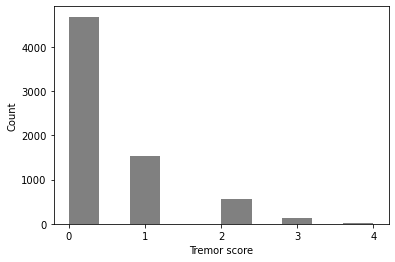

In [5]:
# Get scores
score = df_score['tremor_GENEActivHand'].values
score = np.array(score, dtype=float)
# score distribution
counts, bin_edges = np.histogram(score,bins = range(6))
fig, ax = plt.subplots()
ax.hist(score, histtype='bar', color = 'grey')
ax.set_xlabel('Tremor score')
ax.set_ylabel('Count')
ax.set_xticks([0,1,2,3,4])
# save figure
# plt.savefig(os.path.join(save_path,"Tremor_score_distribution"))
counts

In [6]:
# Merge score 3 and 4
score[score==4] = 3
df_score[df_score['tremor_GENEActivHand']==4]=3

In [7]:
# Upsampling by copying minority class instances

upsampled_df_feature = pd.DataFrame()
upsampled_df_score = pd.DataFrame()
upsample_size = 300
# upsample_size = round(max(counts)/2)
for c,s in zip(counts[0:4],range(4)):
    
    if s == 3:
        df_feature_group = df_feature.loc[score==s]
        df_score_group = df_score.loc[score==s]
        idx_list = df_feature_group.index.tolist()
        resample_idx = resample(idx_list, replace=True, n_samples=upsample_size, random_state=27)
        upsampled_feature_group = df_feature_group.loc[resample_idx]
        upsampled_score_group = df_score_group.loc[resample_idx]
    else:
        upsampled_feature_group = df_feature.loc[score==s]
        upsampled_score_group = df_score.loc[score==s]
        
#     if c == max(counts):
#         upsampled_feature_group = df_feature.loc[score==s]
#         upsampled_score_group = df_score.loc[score==s]
#     else:
#         df_feature_group = df_feature.loc[score==s]
#         df_score_group = df_score.loc[score==s]
#         idx_list = df_feature_group.index.tolist()
#         resample_idx = resample(idx_list, replace=True, n_samples=upsample_size, random_state=27)
#         upsampled_feature_group = df_feature_group.loc[resample_idx]
#         upsampled_score_group = df_score_group.loc[resample_idx]

    upsampled_df_feature = pd.concat([upsampled_df_feature, upsampled_feature_group])
    upsampled_df_score = pd.concat([upsampled_df_score, upsampled_score_group])

    
upsampled_df_feature = upsampled_df_feature.reset_index(drop=True)
upsampled_df_score = upsampled_df_score.reset_index(drop=True)
   
print('upsampled features:' + str(upsampled_df_feature.shape))
print('upsampled scores:' + str(upsampled_df_score.shape))

# Try other upsmapling methods:
# from imblearn.over_sampling import SMOTE


upsampled features:(7066, 2262)
upsampled scores:(7066, 11)


In [8]:
# Try different task categories
# task categories
task_groups = [['stndg', 'sittg'],['wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd'],
               ['ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng'],
              ['stndg', 'sittg', 'wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd',
              'ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng']]
task_group_names = ['no_voluntary_movement','whole_body_movement', 'upperlimb_movement', 'all']

In [9]:
# Train/Validation/Test datasets

# train:validation:test = 0.5:0.25:0.25
sb_train = ['6_BOS', '16_BOS', '7_NYC', '14_BOS', '8_NYC', '5_BOS', '12_NYC', '6_NYC', '17_BOS',
           '4_BOS', '11_BOS', '10_BOS', '15_BOS', '4_NYC', '11_NYC']
sb_val = ['8_BOS', '18_BOS', '2_NYC', '9_NYC', '3_BOS', '9_BOS']
sb_test = ['19_BOS', '3_NYC', '7_BOS', '5_NYC', '13_BOS', '10_NYC', '12_BOS']


In [10]:
# Train/Test Split
is_train = upsampled_df_score['subject_id'].isin(sb_train).tolist()
is_val = upsampled_df_score['subject_id'].isin(sb_val).tolist()
is_test = upsampled_df_score['subject_id'].isin(sb_test).tolist()
is_train_val = upsampled_df_score['subject_id'].isin(sb_train) | upsampled_df_score['subject_id'].isin(sb_val)
is_train_val = is_train_val.tolist()

df_feature_train = upsampled_df_feature[is_train]
df_score_train = upsampled_df_score[is_train]
df_feature_val = upsampled_df_feature[is_val]
df_score_val = upsampled_df_score[is_val]
df_feature_test = upsampled_df_feature[is_test]
df_score_test = upsampled_df_score[is_test]

In [ ]:
# model selection

In [11]:
# all tasks

# Remove features with nan
df_feature2 = upsampled_df_feature.dropna(axis=1)

# Remove features with zero variance
sel = VarianceThreshold(threshold=0.0001)
df_feature3 = sel.fit_transform(df_feature2)
filter3 = sel.get_support()
feature_names2 = df_feature2.columns
feature_names3 = feature_names2[filter3]
df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)

# Get scores
score = upsampled_df_score['tremor_GENEActivHand'].values
# score = upsampled_df_score['tremor_PebbleHand'].values
score = np.array(score, dtype=float)

# # Merge score 3 and 4
# score[score==4] = 3
score[score<3] = 0
score[score>2] = 1

# Univariate Selection
test = SelectKBest(score_func=f_classif, k=10)
df_feature4 = test.fit_transform(df_feature3, score)
filter4 = test.get_support()
feature_names4 = feature_names3[filter4]
df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

# PCA
X=df_feature4.values
pca = PCA(n_components=3)
X_new = pca.fit_transform(X)

# train/validation/test split
X_train_valid = X_new[is_train_val,:]
y_train_valid = score[is_train_val]
X_train = X_new[is_train,:]
y_train = score[is_train]
X_valid = X_new[is_val,:]
y_valid = score[is_val]
X_test = X_new[is_test,:]
y_test = score[is_test]

In [ ]:
# Hyperparameter tuning
# hyper = [30, 50, 100, 150 , 200] #- choose 100
# nPC = [3, 10, 30, 50, 100]- choose 30
# tree_depth = [None, 2, 5 , 10]- choose None max_depth
# tree_number = [30, 50, 100, 200, 300]- doesn't matter, use default 100 n_estimators
# criterion_algo = ['gini', 'entropy'] - doesn't matter, use default gini criterion
# min_samples_split = [2, 5, 10, 20] - doesn't matter, use default 2 min_samples_split
# max_features = ['sqrt', 'log2', None] - doesn't matter, use default sqrt max_features

# hyper = ['sqrt', 'log2', None] # max_features
# accuracy = np.zeros([len(hyper),len(task_groups)])
accuracy = np.zeros([1,len(task_groups)])
for t,task,task_name in zip(range(len(task_groups)),task_groups, task_group_names):
    is_tasks = upsampled_df_score['task_code'].isin(task).tolist()
    df_feature_task = upsampled_df_feature[is_tasks]
    df_score_task = upsampled_df_score[is_tasks]
    
    # Remove features with nan
    df_feature2 = df_feature_task.dropna(axis=1)
    
    # Remove features with zero variance
    sel = VarianceThreshold(threshold=0.0001)
    df_feature3 = sel.fit_transform(df_feature2)
    filter3 = sel.get_support()
    feature_names2 = df_feature2.columns
    feature_names3 = feature_names2[filter3]
    df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)
    
    # Get scores
    score = df_score_task['tremor_GENEActivHand'].values
    score = np.array(score, dtype=float)

#     for i,d in zip(range(len(hyper)), hyper):
        # Univariate Selection
    test = SelectKBest(score_func=f_classif, k=100)
    df_feature4 = test.fit_transform(df_feature3, score)
    filter4 = test.get_support()
    feature_names4 = feature_names3[filter4]
    df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

    # PCA
    X=df_feature4.values
    pca = PCA(n_components=30)
    X_new = pca.fit_transform(X)

    # Random Forest
    # Tuning hyperparameters
    # train/validation split
    is_train_task = list(compress(is_train,is_tasks))
    is_val_task = list(compress(is_val,is_tasks))
    X_train = X_new[is_train_task,:]
    y_train = score[is_train_task]
    X_val = X_new[is_val_task,:]
    y_val = score[is_val_task]

    #     for i,d in zip(range(len(hyper)), hyper):
    clf = RandomForestClassifier(max_depth = None, random_state=0)
    clf.fit(X_train, y_train)
    model_accuracy = round(clf.score(X_val, y_val)*100,1)
    accuracy[0][t] = model_accuracy


In [ ]:
accuracy = pd.DataFrame(data=accuracy, columns=task_group_names)
accuracy

# No up- or down- sampling

In [ ]:
# Try different task categories
# task categories
task_groups = [['stndg', 'sittg'],['wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd'],
               ['ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng'],
              ['stndg', 'sittg', 'wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd',
              'ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng']]
task_group_names = ['no_voluntary_movement','whole_body_movement', 'upperlimb_movement', 'all']

In [ ]:
# Train/Validation/Test datasets

# train:validation:test = 0.5:0.25:0.25
sb_train = ['6_BOS', '16_BOS', '7_NYC', '14_BOS', '8_NYC', '5_BOS', '12_NYC', '6_NYC', '17_BOS',
           '4_BOS', '11_BOS', '10_BOS', '15_BOS', '4_NYC', '11_NYC']
sb_val = ['8_BOS', '18_BOS', '2_NYC', '9_NYC', '3_BOS', '9_BOS']
sb_test = ['19_BOS', '3_NYC', '7_BOS', '5_NYC', '13_BOS', '10_NYC', '12_BOS']

In [ ]:
# Train/Validation/Test Split
is_train = df_score['subject_id'].isin(sb_train).tolist()
is_val = df_score['subject_id'].isin(sb_val).tolist()
is_test = df_score['subject_id'].isin(sb_test).tolist()
is_train_val = df_score['subject_id'].isin(sb_train) | df_score['subject_id'].isin(sb_val)
is_train_val = is_train_val.tolist()

df_feature_train = df_feature[is_train]
df_score_train = df_score[is_train]
df_feature_val = df_feature[is_val]
df_score_val = df_score[is_val]
df_feature_test = df_feature[is_test]
df_score_test = df_score[is_test]

In [ ]:
# Hyperparameter tuning
# kbest = [30, 50, 100, 150 , 200]- choose 100
# nPC = [3, 10, 30, 50, 100]- choose 30
# tree_depth = [None, 2, 5 , 10]- choose None max_depth
# tree_number = [30, 50, 100, 200, 300]- doesn't matter, use default 100 n_estimators
# criterion_algo = ['gini', 'entropy'] - doesn't matter, use default gini criterion
# min_samples_split = [2, 5, 10, 20] - doesn't matter, use default 2 min_samples_split
# max_features = ['sqrt', 'log2', None] - doesn't matter, use default sqrt max_features

# hyper = ['sqrt', 'log2', None] # max_features
# accuracy = np.zeros([len(hyper),len(task_groups)])
accuracy = np.zeros([1,len(task_groups)])

for t,task,task_name in zip(range(len(task_groups)),task_groups, task_group_names):
    is_tasks = df_score['task_code'].isin(task).tolist()
    df_feature_task = df_feature[is_tasks]
    df_score_task = df_score[is_tasks]
    
    # Remove features with nan
    df_feature2 = df_feature_task.dropna(axis=1)
    
    # Remove features with zero variance
    sel = VarianceThreshold(threshold=0.0001)
    df_feature3 = sel.fit_transform(df_feature2)
    filter3 = sel.get_support()
    feature_names2 = df_feature2.columns
    feature_names3 = feature_names2[filter3]
    df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)
    
    # Get scores
#     score = df_score_task['dyskinesia_PebbleHand']
    score = df_score_task['tremor_GENEActivHand'].values
#     score = np.array(score, dtype=float)
    
#     Merge score 3 and 4
#     score[score==4] = 3
    
    # Univariate Selection
    test = SelectKBest(score_func=f_classif, k=100)
    df_feature4 = test.fit_transform(df_feature3, score)
    filter4 = test.get_support()
    feature_names4 = feature_names3[filter4]
    df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)
    
    # PCA
    X=df_feature4.values
    pca = PCA(n_components=30)
    X_new = pca.fit_transform(X)

    # Random Forest
    # Tuning hyperparameters
    # train/validation split
    is_train_task = list(compress(is_train,is_tasks))
    is_val_task = list(compress(is_val,is_tasks))
    X_train = X_new[is_train_task,:]
    y_train = score[is_train_task]
    X_val = X_new[is_val_task,:]
    y_val = score[is_val_task]
    
#     for i,d in zip(range(len(hyper)), hyper):
    clf = RandomForestClassifier(max_depth = None, random_state=0)
    clf.fit(X_train, y_train)
    model_accuracy = round(clf.score(X_val, y_val)*100,1)
#     accuracy[i][t] = model_accuracy
    accuracy[0][t] = model_accuracy


In [ ]:
accuracy = pd.DataFrame(data=accuracy, columns=task_group_names)
accuracy

In [ ]:
accuracy = np.zeros([1,len(task_groups)])

for t,task,task_name in zip(range(len(task_groups)),task_groups, task_group_names):
    is_tasks = df_score['task_code'].isin(task).tolist()
    df_feature_task = df_feature[is_tasks]
    df_score_task = df_score[is_tasks]
    
    # Remove features with nan
    df_feature2 = df_feature_task.dropna(axis=1)
    
    # Remove features with zero variance
    sel = VarianceThreshold(threshold=0.0001)
    df_feature3 = sel.fit_transform(df_feature2)
    filter3 = sel.get_support()
    feature_names2 = df_feature2.columns
    feature_names3 = feature_names2[filter3]
    df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)
    
    # Get scores
    score = df_score_task['tremor_PebbleHand'].values
    score = np.array(score, dtype=float)
    
    # Merge score 3 and 4
    score[score==4] = 3
    
    # Univariate Selection
    test = SelectKBest(score_func=f_classif, k=100)
    df_feature4 = test.fit_transform(df_feature3, score)
    filter4 = test.get_support()
    feature_names4 = feature_names3[filter4]
    df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)
    
    # PCA
    X=df_feature4.values
    pca = PCA(n_components=30)
    X_new = pca.fit_transform(X)

    # Random Forest
    # Tuning hyperparameters
    # train/test split
    is_train_task = list(compress(is_train,is_tasks))
    is_test_task = list(compress(is_test,is_tasks))
    X_train = X_new[is_train_task,:]
    y_train = score[is_train_task]
    X_test = X_new[is_test_task,:]
    y_test = score[is_test_task]
    
#     for i,d in zip(range(len(hyper)), hyper):
    clf = RandomForestClassifier(max_depth = None, random_state=0)
    clf.fit(X_train, y_train)
    model_accuracy = round(clf.score(X_test, y_test)*100,1)
#     accuracy[i][t] = model_accuracy
    accuracy[0][t] = model_accuracy

In [ ]:
accuracy = pd.DataFrame(data=accuracy, columns=task_group_names)
accuracy

In [ ]:
# Confusion metrix 
# all tasks

# Remove features with nan
df_feature2 = df_feature.dropna(axis=1)

# Remove features with zero variance
sel = VarianceThreshold(threshold=0.0001)
df_feature3 = sel.fit_transform(df_feature2)
filter3 = sel.get_support()
feature_names2 = df_feature2.columns
feature_names3 = feature_names2[filter3]
df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)

# Get scores
score = df_score_task['tremor_GENEActivHand'].values
score = np.array(score, dtype=float)

# Merge score 3 and 4
score[score==4] = 3

# Univariate Selection
test = SelectKBest(score_func=f_classif, k=100)
df_feature4 = test.fit_transform(df_feature3, score)
filter4 = test.get_support()
feature_names4 = feature_names3[filter4]
df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

# PCA
X=df_feature4.values
pca = PCA(n_components=30)
X_new = pca.fit_transform(X)

# train/test split
X_train = X_new[is_train,:]
y_train = score[is_train]
X_test = X_new[is_test,:]
y_test = score[is_test]
# Random Forest
clf = RandomForestClassifier(max_depth = None, random_state=0)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
cm

In [ ]:
Accuracy = metrics.accuracy_score(y_test, predictions)
Precision = metrics.precision_score(y_test, predictions, average = None)
Recall = metrics.recall_score(y_test, predictions, average = None)
F1 = metrics.f1_score(y_test, predictions, average = None)

In [ ]:
Precision

In [ ]:
Recall

In [ ]:
F1

In [ ]:
F1_weighted = metrics.f1_score(y_test, predictions, average = 'weighted')

In [ ]:
F1_weighted

In [ ]:
# Model selection and evaluation

In [ ]:
# all tasks

# Remove features with nan
df_feature2 = df_feature.dropna(axis=1)

# Remove features with zero variance
sel = VarianceThreshold(threshold=0.0001)
df_feature3 = sel.fit_transform(df_feature2)
filter3 = sel.get_support()
feature_names2 = df_feature2.columns
feature_names3 = feature_names2[filter3]
df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)

# Get scores
score = df_score['tremor_GENEActivHand'].values
# score = df_score['tremor_PebbleHand'].values
score = np.array(score, dtype=float)

# Merge score 3 and 4
score[score==4] = 3

# Univariate Selection
test = SelectKBest(score_func=f_classif, k=30)
df_feature4 = test.fit_transform(df_feature3, score)
filter4 = test.get_support()
feature_names4 = feature_names3[filter4]
df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

# PCA
X=df_feature4.values
pca = PCA(n_components=10)
X_new = pca.fit_transform(X)

# train/validation/test split
X_train_valid = X_new[is_train_val,:]
y_train_valid = score[is_train_val]
X_train = X_new[is_train,:]
y_train = score[is_train]
X_valid = X_new[is_val,:]
y_valid = score[is_val]
X_test = X_new[is_test,:]
y_test = score[is_test]

In [12]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0, solver = 'liblinear'),
    "KNN" : KNeighborsClassifier(),
#     "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    #"XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
#     "LGBM" : LGBMClassifier(random_state=0),
#     "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

# SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
#             'kernel': ['linear', 'rbf'],
#             'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

# boosted_grid = {'n_estimators': [50, 100, 150, 200],
#         'max_depth': [4, 8, 12],
#         'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
#     "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
#     "XGBoost" : boosted_grid,
#     "LGBM" : boosted_grid,
#     "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [13]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

Model: LogisticRegression
Training time (mins): 0.04

Model: KNN
Training time (mins): 0.0

Model: RandomForest
Training time (mins): 0.19

Model: NaiveBayes
Training time (mins): 0.0



In [14]:
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.950294,0.04
1,KNN,0.939830,0.00
2,RandomForest,0.948332,0.19
3,NaiveBayes,0.931982,0.00


In [15]:
clf_best_params

{'LogisticRegression': {'C': 0.25, 'max_iter': 50, 'penalty': 'l1'},
 'KNN': {'n_neighbors': 3, 'p': 2},
 'RandomForest': {'max_depth': 12, 'n_estimators': 50},
 'NaiveBayes': {'var_smoothing': 1e-10}}

In [16]:
# best classifiers
RF_best = RandomForestClassifier(**clf_best_params["RandomForest"], verbose=False, random_state=0)
RF_best.fit(X_train_valid, y_train_valid)
y_pred = RF_best.predict(X_test)

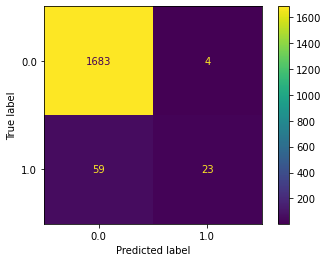

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [18]:
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred, average = None)
Recall = recall_score(y_test, y_pred, average = None)
F1 = f1_score(y_test, y_pred, average = None)

In [19]:
Accuracy

0.9643866591294517

In [20]:
Precision

array([0.96613088, 0.85185185])

In [21]:
Recall

array([0.99762893, 0.2804878 ])

In [22]:
F1

array([0.9816273 , 0.42201835])

In [23]:
F1_weighted = f1_score(y_test, y_pred, average = 'weighted')

In [24]:
F1_weighted

0.9556872549072855

In [ ]:
y_test

In [ ]:
len(y_test)

# Draft

In [ ]:
for task,task_name in zip(task_groups, task_group_names):
    is_tasks = df_score['task_code'].isin(task).tolist()
    df_feature_task = df_feature[is_tasks]
    df_score_task = df_score[is_tasks]
    
    # Remove features with nan
    df_feature2 = df_feature_task.dropna(axis=1)
    
    # Remove features with zero variance
    sel = VarianceThreshold(threshold=0.0001)
    df_feature3 = sel.fit_transform(df_feature2)
    filter3 = sel.get_support()
    feature_names2 = df_feature2.columns
    feature_names3 = feature_names2[filter3]
    df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)

    
    # Univariate Selection
    test = SelectKBest(score_func=f_classif, k=50)
    df_feature4 = test.fit_transform(df_feature3, score)
    filter4 = test.get_support()
    feature_names4 = feature_names3[filter4]
    df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)
    
    # PCA
    X=df_feature3.values
    pca = PCA(n_components=10)
    fit = pca.fit(X)
    cumulative_EV = np.cumsum(fit.explained_variance_ratio_)
    
    X_new = pca.fit_transform(X)
    PC1 = X_new[:,0]
    x = PC1
    y = score
    fig, ax = plt.subplots()
    ax.scatter(x,y,facecolors='none', edgecolors='b')
    ax.set_xlabel('PC1' + '(' + str(round(cumulative_EV[0],2)*100) + '%)')
    ax.set_ylabel('Tremor score')
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(['0','1','2','3/4'])
    ax.set_title(task_name)
    
    # save figure
    file_name = 'PC1' + '_' + task_name
    plt.savefig(os.path.join(save_path,'PCA_50', file_name))

In [ ]:
# subjects in the training dataset
# train:test = 0.67:0.33
# sb_train = ['11_NYC', '6_BOS', '8_BOS', '2_NYC', '7_NYC', '5_BOS', '11_BOS', '15_BOS', '4_NYC',
#                 '12_NYC', '6_NYC', '3_BOS', '14_BOS', '18_BOS', '9_NYC', '4_BOS', '9_BOS', '16_BOS']

# # train:test = 0.75:0.25
# sb_train = ['8_BOS', '11_NYC', '2_NYC', '9_NYC', '3_BOS', '8_NYC', '7_NYC', '18_BOS', '15_BOS',
#            '4_NYC', '12_NYC', '9_BOS', '6_NYC', '6_BOS', '16_BOS', '5_BOS', '14_BOS', '4_BOS',
#            '11_BOS', '10_BOS', '17_BOS']
# is_test_sb = ~np.isin(subject_ids, sb_train)
# sb_test = subject_ids[is_test_sb]

In [ ]:
# Remove features with nan
df_feature2 = df_feature.dropna(axis=1)

# Remove features with zero variance
sel = VarianceThreshold()
df_feature3 = sel.fit_transform(df_feature2)
filter3 = sel.get_support()
feature_names2 = df_feature2.columns
feature_names3 = feature_names2[filter3]
df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)

# Get scores
score = df_score['tremor_GENEActivHand'].values
score = np.array(score, dtype=float)

# Merge score 3 and 4
score[score==4] = 3

# Univariate Selection
test = SelectKBest(score_func=f_classif, k=100)
df_feature4 = test.fit_transform(df_feature3, score)
filter4 = test.get_support()
feature_names4 = feature_names3[filter4]
df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

# PCA
X=df_feature4.values
pca = PCA(n_components=10)
X_new = pca.fit_transform(X)
PC1 = X_new[:,0]


In [ ]:
PC1.shape

In [ ]:
X_train = X_new[is_train,0:3]
y_train = score[is_train]
X_test = X_new[is_test,0:3]
y_test = score[is_test]

In [ ]:
# Random forest
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

In [ ]:
clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
hyper

In [ ]:
model_accuracy

In [ ]:
clf = RandomForestClassifier(max_depth=5, random_state=0,  oob_score=True)
clf.fit(X_train, y_train)
model_accuracy_train = round(clf.oob_score_,3)*100
model_accuracy_test = round(clf.score(X_test, y_test),3)*100
